**=== Dogs vs Cats SVM ===**

by **Verindra Hernanda Putra**

# Overview

The overral process is : 

- Data Loading, Exploration, and Preparation
- Splitting Data
- Modelling
- Evaluation
- Submission

# Data Loading, Exploration, and Preparation

Preparation for the dataset, libraries, etc

In [1]:
# Libraries
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from skimage.feature import hog

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Config
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test1/'
N_SAMPLES_PER_CLASS = 7500 
IMG_SIZE = (64, 64) 
RANDOM_STATE = 42

In [4]:
# Data Loading Function
def load_train_data(train_dir, n_samples, img_size):
    feature_list = []
    labels = []
    
    all_filenames = os.listdir(train_dir)
    cat_files = [f for f in all_filenames if f.startswith('cat')]
    dog_files = [f for f in all_filenames if f.startswith('dog')]
    
    random.seed(RANDOM_STATE)
    cat_files_sample = random.sample(cat_files, n_samples)
    dog_files_sample = random.sample(dog_files, n_samples)
    filenames_to_load = cat_files_sample + dog_files_sample
    random.shuffle(filenames_to_load)
    
    print(f"Loading {len(filenames_to_load)} images and extracting features...")
    for filename in tqdm(filenames_to_load):
        try:
            label = 1 if filename.startswith('dog') else 0
            img_path = os.path.join(train_dir, filename)
            img_color = cv2.imread(img_path)
            
            if img_color is not None:
                features = extract_features(img_color, img_size)
                feature_list.append(features)
                labels.append(label)
        except Exception as e:
            print(f"\n[WARNING] Skipping file '{filename}' due to a processing error: {e}")
            continue
            
    return feature_list, labels

In [5]:
def extract_features(img_color, resize_shape):
    # Resize the image to a standard size ONCE.
    img_resized = cv2.resize(img_color, resize_shape)

    # Extract HOG features from the resized image.
    gray_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    hog_vec = hog(gray_resized, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), channel_axis=None)

    # Extract Color Histogram features from the resized image.
    hist_b = cv2.calcHist([img_resized], [0], None, [32], [0, 256])
    hist_g = cv2.calcHist([img_resized], [1], None, [32], [0, 256])
    hist_r = cv2.calcHist([img_resized], [2], None, [32], [0, 256])
    
    color_hist = np.concatenate((hist_b, hist_g, hist_r)).flatten()
    color_hist = cv2.normalize(color_hist, color_hist).flatten()

    # Combine and return the final, fixed-length feature vector.
    combined_features = np.hstack((hog_vec, color_hist))
    return combined_features

In [6]:
# 1. Load Data
features, labels = load_train_data(TRAIN_DIR, N_SAMPLES_PER_CLASS, IMG_SIZE)
X = np.array(features)
y = np.array(labels)
print(f"\nSuccessfully created feature matrix with shape: {X.shape}")

Loading 15000 images and extracting features...


100%|██████████| 15000/15000 [03:10<00:00, 78.76it/s]



Successfully created feature matrix with shape: (15000, 1860)


# Splitting Data

Split the data to train and test

In [7]:
# Train-Validation Split and Scaling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Modelling

Chose SVM model and train with the splitted data

In [8]:
# Train SVM with Fixed Parameters (Fast Baseline)
print("\nTraining SVM model with fixed parameters for a fast baseline...")

model = SVC(C=10, gamma=0.001, kernel='rbf', probability=True, random_state=RANDOM_STATE)

model.fit(X_train_scaled, y_train)
print("Model training complete.")


Training SVM model with fixed parameters for a fast baseline...
Model training complete.


# Evaluation

Evaluate model with confussion matrix to measure the perfomance


Evaluating the baseline model on the validation set...

--- Baseline Validation Classification Report ---
              precision    recall  f1-score   support

     Cat (0)       0.75      0.79      0.77      1500
     Dog (1)       0.78      0.74      0.76      1500

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000


--- Baseline Validation Confusion Matrix ---


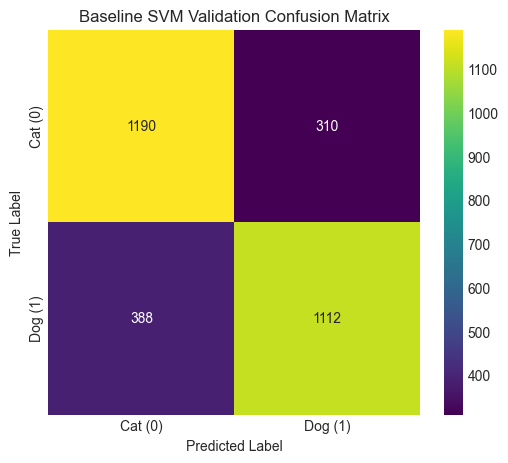

In [9]:
# Evaluate the Final Model
print("\nEvaluating the baseline model on the validation set...")
y_pred_val = model.predict(X_val_scaled)
print("\n--- Baseline Validation Classification Report ---")
print(classification_report(y_val, y_pred_val, target_names=['Cat (0)', 'Dog (1)']))

print("\n--- Baseline Validation Confusion Matrix ---")
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Cat (0)', 'Dog (1)'], yticklabels=['Cat (0)', 'Dog (1)'])
plt.title('Baseline SVM Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Submission

Apply the model to test data and submit it

In [10]:
# Submission File
def generate_submission(model, test_dir, img_size, scaler):
    submission_data = []
    test_files = os.listdir(test_dir)
    test_files.sort(key=lambda x: int(x.split('.')[0]))
    
    print(f"\nProcessing {len(test_files)} test images for submission...")
    for filename in tqdm(test_files):
        try:
            img_id = int(filename.split('.')[0])
            img_path = os.path.join(test_dir, filename)
            img_color = cv2.imread(img_path)
            
            if img_color is not None:
                features = extract_features(img_color, img_size)
                features_reshaped = features.reshape(1, -1)
                features_scaled = scaler.transform(features_reshaped)
                pred_prob = model.predict_proba(features_scaled)[0][1]
                submission_data.append({'id': img_id, 'label': pred_prob})
            else:
                raise ValueError("Image could not be read")
        except Exception as e:
            print(f"\n[WARNING] Test file '{filename}' failed. Using default 0.5. Error: {e}")
            submission_data.append({'id': img_id, 'label': 0.5})
            continue

    submission_df = pd.DataFrame(submission_data)
    submission_df['label'] = submission_df['label'].clip(0.005, 0.995)
    submission_df.to_csv('submission_svm_baseline.csv', index=False)
    
    print("\nBaseline submission file 'submission_svm_baseline.csv' created.")
    return submission_df

submission_df = generate_submission(model, TEST_DIR, IMG_SIZE, scaler)
print("\n--- Baseline Submission File Head ---")
print(submission_df.head())


Processing 12500 test images for submission...


100%|██████████| 12500/12500 [08:49<00:00, 23.61it/s]



Baseline submission file 'submission_svm_baseline.csv' created.

--- Baseline Submission File Head ---
   id     label
0   1  0.792665
1   2  0.860475
2   3  0.727814
3   4  0.972361
4   5  0.513809
